In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pyspark as spark
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
sc = spark.SparkContext()
sql = spark.SQLContext(sc)
from pyspark.sql.types import *
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Single Feature Sentiment Analysis

In [2]:
df = pd.read_csv('btc_value_em_tweets_sentimental_score.csv')
df.columns = ['DateTime','Compound','Positive', 'Neutral', 'Negative', 'Price']
df['Sentiment_score'] = df['Compound']
df = df[['DateTime','Sentiment_score','Price']]

df = df.sort_values('DateTime')
df.head()

,DateTime,Sentiment_score,Price
360,2020-07-01,0.0,9229.9
359,2020-07-02,0.0,9085.1
358,2020-07-03,0.0,9067.1
357,2020-07-04,0.0,9134.4
356,2020-07-05,0.0,9081.0


## Plotting the input variables

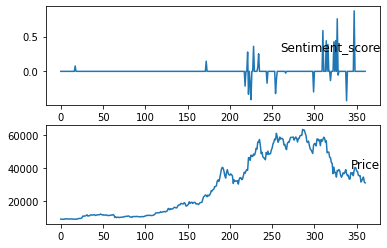

In [3]:
values = df.values
# specify columns to plot
groups = [ 1,2]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

Set index to datetime and change the order of columns

In [4]:
df.set_index('DateTime',inplace=True)  
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df


,Price,Sentiment_score
DateTime,,
2020-07-01,9229.9,0.0
2020-07-02,9085.1,0.0
2020-07-03,9067.1,0.0
2020-07-04,9134.4,0.0
2020-07-05,9081.0,0.0
...,...,...
2021-06-22,32496.4,0.0
2021-06-23,33674.3,0.0
2021-06-24,34665.8,0.0


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    Converts the original dataframe to a format which contains
    lag shifted values of inputs which can be used as input
    to the LSTM
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
n_days = 1  #no of time lags
n_features = 1 #no of features
n_obs = n_days*n_features

In [8]:
reframed = series_to_supervised(scaled, n_days, 1)
reframed.head()

,var1(t-1),var2(t-1),var1(t),var2(t)
1,0.002989,0.326643,0.000330,0.326643
2,0.000330,0.326643,0.000000,0.326643
3,0.000000,0.326643,0.001235,0.326643
4,0.001235,0.326643,0.000255,0.326643
5,0.000255,0.326643,0.004991,0.326643


In [9]:
reframed = reframed.drop(reframed.columns[-1], axis=1)
reframed.head()

,var1(t-1),var2(t-1),var1(t)
1,0.002989,0.326643,0.000330
2,0.000330,0.326643,0.000000
3,0.000000,0.326643,0.001235
4,0.001235,0.326643,0.000255
5,0.000255,0.326643,0.004991


In [10]:
values = reframed.values
n_train_days = 251
train = values[:n_train_days, :]
test = values[n_train_days:, :]
train.shape

(251, 3)

In [11]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [12]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(251, 1, 1) (251,) (109, 1, 1) (109,)


In [13]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history


Epoch 1/7
63/63 - 2s - loss: 0.1924 - val_loss: 0.6517
Epoch 2/7
63/63 - 0s - loss: 0.1891 - val_loss: 0.6145
Epoch 3/7
63/63 - 0s - loss: 0.1838 - val_loss: 0.5837
Epoch 4/7
63/63 - 0s - loss: 0.1783 - val_loss: 0.5542
Epoch 5/7
63/63 - 0s - loss: 0.1721 - val_loss: 0.5232
Epoch 6/7
63/63 - 0s - loss: 0.1653 - val_loss: 0.4897
Epoch 7/7
63/63 - 0s - loss: 0.1569 - val_loss: 0.4511


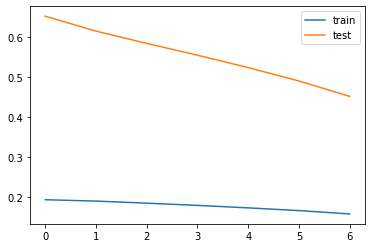

In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [15]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 25745.025


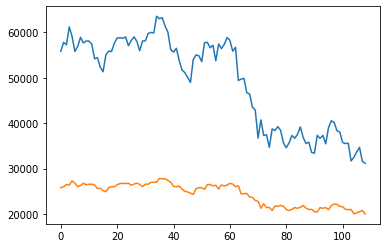

In [16]:
plt.plot(inv_y)
plt.plot(inv_yhat)
plt.show()

## Multifeature Sentiment Analysis

In [17]:
df = pd.read_csv('btc_value_em_tweets_sentimental_score.csv')
df.columns = ['DateTime','Compound','Positive', 'Neutral', 'Negative', 'Price']
df = df[['DateTime','Negative','Neutral','Positive','Compound','Price']]
df = df.sort_values('DateTime')
df1 = df
df.head()

,DateTime,Negative,Neutral,Positive,Compound,Price
360,2020-07-01,0.0,0.0,0.0,0.0,9229.9
359,2020-07-02,0.0,0.0,0.0,0.0,9085.1
358,2020-07-03,0.0,0.0,0.0,0.0,9067.1
357,2020-07-04,0.0,0.0,0.0,0.0,9134.4
356,2020-07-05,0.0,0.0,0.0,0.0,9081.0


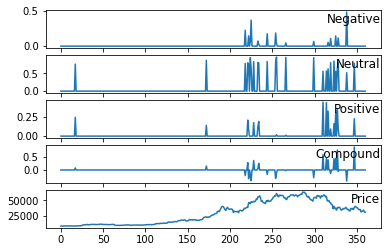

In [18]:
values = df1.values
# specify columns to plot
groups = [ 1,2,3,4,5]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df1.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [19]:
df1.set_index('DateTime',inplace=True)

In [20]:
cols = df1.columns.tolist()
cols = cols[-1:] + cols[:-1]
df1 = df1[cols]
df1.head()

,Price,Negative,Neutral,Positive,Compound
DateTime,,,,,
2020-07-01,9229.9,0.0,0.0,0.0,0.0
2020-07-02,9085.1,0.0,0.0,0.0,0.0
2020-07-03,9067.1,0.0,0.0,0.0,0.0
2020-07-04,9134.4,0.0,0.0,0.0,0.0
2020-07-05,9081.0,0.0,0.0,0.0,0.0


In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df1.values)

In [22]:
n_days = 1
n_features = 5
n_obs = n_days*n_features

In [23]:
reframed = series_to_supervised(scaled, n_days, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,0.002989,0.0,0.0,0.0,0.326643,0.000330,0.0,0.0,0.0,0.326643
2,0.000330,0.0,0.0,0.0,0.326643,0.000000,0.0,0.0,0.0,0.326643
3,0.000000,0.0,0.0,0.0,0.326643,0.001235,0.0,0.0,0.0,0.326643
4,0.001235,0.0,0.0,0.0,0.326643,0.000255,0.0,0.0,0.0,0.326643
5,0.000255,0.0,0.0,0.0,0.326643,0.004991,0.0,0.0,0.0,0.326643


In [24]:
reframed = reframed.drop(reframed.columns[-4:], axis=1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.002989,0.0,0.0,0.0,0.326643,0.000330
2,0.000330,0.0,0.0,0.0,0.326643,0.000000
3,0.000000,0.0,0.0,0.0,0.326643,0.001235
4,0.001235,0.0,0.0,0.0,0.326643,0.000255
5,0.000255,0.0,0.0,0.0,0.326643,0.004991


In [25]:
values = reframed.values
n_train_days = 251
train = values[:n_train_days, :]
test = values[n_train_days:, :]
train.shape

(251, 6)

In [26]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [27]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(251, 1, 5) (251,) (109, 1, 5) (109,)


In [28]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

Epoch 1/20
63/63 - 1s - loss: 0.0124 - val_loss: 0.0270
Epoch 2/20
63/63 - 0s - loss: 0.0151 - val_loss: 0.0234
Epoch 3/20
63/63 - 0s - loss: 0.0091 - val_loss: 0.0217
Epoch 4/20
63/63 - 0s - loss: 0.0084 - val_loss: 0.0213
Epoch 5/20
63/63 - 0s - loss: 0.0088 - val_loss: 0.0199
Epoch 6/20
63/63 - 0s - loss: 0.0086 - val_loss: 0.0200
Epoch 7/20
63/63 - 0s - loss: 0.0086 - val_loss: 0.0193
Epoch 8/20
63/63 - 0s - loss: 0.0077 - val_loss: 0.0183
Epoch 9/20
63/63 - 0s - loss: 0.0075 - val_loss: 0.0183
Epoch 10/20
63/63 - 0s - loss: 0.0077 - val_loss: 0.0184
Epoch 11/20
63/63 - 0s - loss: 0.0068 - val_loss: 0.0186
Epoch 12/20
63/63 - 0s - loss: 0.0066 - val_loss: 0.0187
Epoch 13/20
63/63 - 0s - loss: 0.0070 - val_loss: 0.0186
Epoch 14/20
63/63 - 0s - loss: 0.0066 - val_loss: 0.0187
Epoch 15/20
63/63 - 0s - loss: 0.0063 - val_loss: 0.0186
Epoch 16/20
63/63 - 0s - loss: 0.0057 - val_loss: 0.0183
Epoch 17/20
63/63 - 0s - loss: 0.0060 - val_loss: 0.0182
Epoch 18/20
63/63 - 0s - loss: 0.0053 - 

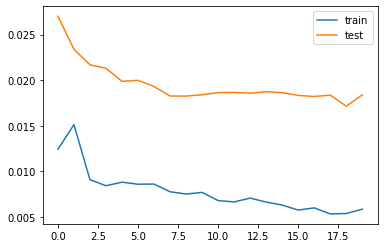

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [30]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3847.871


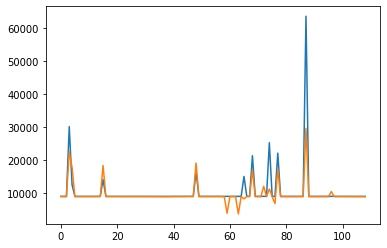

In [31]:
plt.plot(inv_y)
plt.plot(inv_yhat)

In [32]:
plt.show()

In [33]:
df_sol = pd.DataFrame({'forecast':inv_yhat,'actual':inv_y})
df_sol.to_csv('Predictions_nosent.csv')